### Import Libraries

In [42]:
# import SentimentIntensityAnalyzer class 
# from vaderSentiment.vaderSentiment module. 
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords 

import re, json, urllib
import pandas as pd
import requests 
from bs4 import BeautifulSoup 
import seaborn as sns
import sqlalchemy as db

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\navee\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\navee\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Sentimental Analysis using SentimentIntensityAnalyzer

In [29]:
def sentiment_scores(filtered_sentence): 
    # Create a SentimentIntensityAnalyzer object. 
    sid_obj = SentimentIntensityAnalyzer() 

    # polarity_scores method of SentimentIntensityAnalyzer 
    # oject gives a sentiment dictionary. 
    # which contains pos, neg, neu, and compound scores. 
    
    sentiment_dict = sid_obj.polarity_scores(filtered_sentence) 
 
    if sentiment_dict['compound'] >= 0.05 : 
        sentiment_dict['sentiment'] = 'Positive'
    elif sentiment_dict['compound'] <= - 0.05 : 
        sentiment_dict['sentiment'] = 'Negative'
    else :
        sentiment_dict['sentiment'] = 'Neutral'
    return sentiment_dict

### Clean Sentence

In [30]:
def clean_sentence(sentence):
    # Clean the sentence for stpwords
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(sentence) 
    filtered_words = [word for word in word_tokens if word not in stop_words and word.isalpha()]
    return ' '.join(filtered_words)

In [31]:
# Read the dataframe from a csv file
df = pd.read_csv('retailers_merged.csv')

In [32]:
df.head()

,public_date,user_name,retailer,review_text
0,a day ago,Alex Wersonig,loblaws,Busy place. Wide isle . Covid lockdown anythin...
1,a day ago,sarah dunlop,loblaws,produce is pretty good which is always my main...
2,a day ago,Petra Perry,loblaws,"Clean, spacious, helpful, polite, 9ts worth pa..."
3,4 days ago,Jenny,loblaws,We get curbside pick up currently and its very...
4,6 days ago,Lana Kis,loblaws,We usually cannot afford to buy food from such...


In [33]:
# Perform Sentiment analysis on the data in the dataframe
sentiment_data = []
for index, row in df.iterrows():
    cleaned_sentence = clean_sentence(row['review_text'])
    sentiment = sentiment_scores(cleaned_sentence)
    sentiment['public_date'] = row['public_date']
    sentiment['user_name'] = row['user_name']
    sentiment['retailer'] = row['retailer']
    sentiment['review_text'] = row['review_text']
    sentiment['cleaned_sentence'] = cleaned_sentence
    sentiment_data.append(sentiment)

In [44]:
# Reorder the columns in the dataframe
sentiment_df = pd.DataFrame(sentiment_data)
columns = ['public_date', 'user_name', 'retailer', 'review_text', 'neg', 'neu', 'pos', 'compound', 'sentiment']
sentiment_df = sentiment_df[columns]

In [45]:
sentiment_df.head()

,public_date,user_name,retailer,review_text,neg,neu,pos,compound,sentiment
0,a day ago,Alex Wersonig,loblaws,Busy place. Wide isle . Covid lockdown anythin...,0.000,1.000,0.000,0.0000,Neutral
1,a day ago,sarah dunlop,loblaws,produce is pretty good which is always my main...,0.000,0.463,0.537,0.8910,Positive
2,a day ago,Petra Perry,loblaws,"Clean, spacious, helpful, polite, 9ts worth pa...",0.000,0.448,0.552,0.7506,Positive
3,4 days ago,Jenny,loblaws,We get curbside pick up currently and its very...,0.000,0.496,0.504,0.7269,Positive
4,6 days ago,Lana Kis,loblaws,We usually cannot afford to buy food from such...,0.302,0.604,0.094,-0.9650,Negative


In [46]:
# Fetch the database configuration from the config.json file
config = {}
with open('config.json', 'r') as c:
    config = json.load(c)

In [47]:
# Create a SQLAlchemy database engine for the azure SQL database server
server = config['SERVER_NAME']
database = config['DB_NAME']
username = config['USERNAME']
password = config['PASSWORD']
params = urllib.parse.quote_plus(r'Driver={ODBC Driver 17 for SQL Server};Server='+server+';Database='+database+';Uid='+username+';Pwd='+ password+';Encrypt=yes;TrustServerCertificate=no;Connection Timeout=30;')
engine = db.create_engine('mssql+pyodbc:///?odbc_connect={}'.format(params), echo=True)

In [51]:
# Create and insert the final data frame into an Azure SQL database
table = sentiment_df.to_sql('retailers', engine, if_exists='replace', index=False)

2021-04-11 17:27:47,932 INFO sqlalchemy.engine.base.Engine SELECT [INFORMATION_SCHEMA].[COLUMNS].[TABLE_SCHEMA], [INFORMATION_SCHEMA].[COLUMNS].[TABLE_NAME], [INFORMATION_SCHEMA].[COLUMNS].[COLUMN_NAME], [INFORMATION_SCHEMA].[COLUMNS].[IS_NULLABLE], [INFORMATION_SCHEMA].[COLUMNS].[DATA_TYPE], [INFORMATION_SCHEMA].[COLUMNS].[ORDINAL_POSITION], [INFORMATION_SCHEMA].[COLUMNS].[CHARACTER_MAXIMUM_LENGTH], [INFORMATION_SCHEMA].[COLUMNS].[NUMERIC_PRECISION], [INFORMATION_SCHEMA].[COLUMNS].[NUMERIC_SCALE], [INFORMATION_SCHEMA].[COLUMNS].[COLUMN_DEFAULT], [INFORMATION_SCHEMA].[COLUMNS].[COLLATION_NAME] 
FROM [INFORMATION_SCHEMA].[COLUMNS] 
WHERE [INFORMATION_SCHEMA].[COLUMNS].[TABLE_NAME] = CAST(? AS NVARCHAR(max)) AND [INFORMATION_SCHEMA].[COLUMNS].[TABLE_SCHEMA] = CAST(? AS NVARCHAR(max))
2021-04-11 17:27:47,934 INFO sqlalchemy.engine.base.Engine ('retailers', 'dbo')
2021-04-11 17:27:50,452 INFO sqlalchemy.engine.base.Engine SELECT [INFORMATION_SCHEMA].[COLUMNS].[TABLE_SCHEMA], [INFORMATION_S

2021-04-11 17:28:17,066 INFO sqlalchemy.engine.base.Engine COMMIT


In [52]:
# Select all the records in the SQL database
results = engine.execute('SELECT * FROM retailers;')

2021-04-11 17:28:17,155 INFO sqlalchemy.engine.base.Engine SELECT * FROM retailers;
2021-04-11 17:28:17,160 INFO sqlalchemy.engine.base.Engine ()


In [53]:
# Iterate and print the query results.
for result in results:
    print(result)

('a day ago', 'Alex Wersonig', 'loblaws', "Busy place. Wide isle . Covid lockdown anything not grocery can't access it", 0.0, 1.0, 0.0, 0.0, 'Neutral')
('a day ago', 'sarah dunlop', 'loblaws', 'produce is pretty good which is always my main concern with any grocery store. prices r fair. staff r friendly.', 0.0, 0.463, 0.537, 0.891, 'Positive')
('a day ago', 'Petra Perry', 'loblaws', 'Clean, spacious, helpful, polite, 9ts worth paying the extra few dollars to shop here.', 0.0, 0.448, 0.552, 0.7506, 'Positive')
('4 days ago', 'Jenny', 'loblaws', 'We get curbside pick up currently and its very quick, easy and friendly.', 0.0, 0.496, 0.504, 0.7269, 'Positive')
('6 days ago', 'Lana Kis', 'loblaws', 'We usually cannot afford to buy food from such an expensive store.  But today we came to it because there was a huge queue in the neighboring wallmar ... (408 characters truncated) ... isgusting!  The managers of this store are not doing their job.  I have not seen such a shame in the most inexp

('6 months ago', 'Stacey Curry', 'no_frills', "No organic produce options sadly.Have to drive to the further away Chris's no frill to get my organic meat and veggies.", 0.167, 0.833, 0.0, -0.296, 'Negative')
('7 months ago', 'Dave Henderson', 'no_frills', 'Great selection', 0.0, 0.196, 0.804, 0.6249, 'Positive')
('7 months ago', 'Emily Schrader', 'no_frills', 'It was quite crowded, and a little hard to social distance. Other than that, great experience. The employees were very helpful and friendly, and the selection was immaculate.', 0.058, 0.511, 0.43, 0.8667, 'Positive')
('7 months ago', 'eric rodrigues', 'no_frills', 'Great place to shop for stuff!', 0.0, 0.423, 0.577, 0.6249, 'Positive')
('7 months ago', 'Rebecca Monkman', 'no_frills', "Went into buy groceries. They had product sign for one price that scanned for a different price and wouldn't honor the signed pricing. Just a disappointing way to end our grocery shopping.", 0.126, 0.748, 0.126, 0.0, 'Neutral')
('3 months ago', 'Ant

('5 months ago', 'Craig Ivory', 'zehrs', "It's better to buy your booze here than throw it was at a unionized gov't monopoly.", 0.0, 0.674, 0.326, 0.4404, 'Positive')
('5 months ago', 'Kari Smith', 'zehrs', 'Always very friendly cashiers! Still get a little confused what section I need to line up in due to covid.', 0.124, 0.679, 0.197, 0.2944, 'Positive')
('6 months ago', 'Alyson Morrison', 'zehrs', 'There is a good variety, out of paper towels and they need more cashiers on a Friday before a long weekend.', 0.0, 0.756, 0.244, 0.4404, 'Positive')
('6 months ago', 'Melanie Orr', 'zehrs', 'Well stocked and friendly staff', 0.0, 0.274, 0.726, 0.6486, 'Positive')
('6 months ago', 'Jason Rodgers', 'zehrs', "Click n collect save time don't forget to tip the workers", 0.171, 0.541, 0.288, 0.3182, 'Positive')
('6 months ago', 'Guy Pare', 'zehrs', 'Its clean, friendly staff . Coffee is great. Snacks & sandwiches are better than the large chain coffee shops', 0.0, 0.411, 0.589, 0.9169, 'Positive

<AxesSubplot:xlabel='sentiment', ylabel='count'>

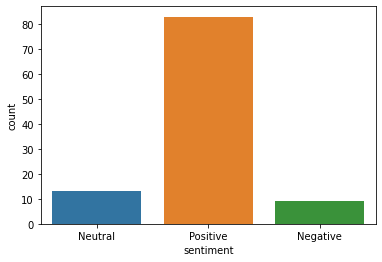

In [57]:
sns.countplot(x="sentiment", data=sentiment_df)